In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import numpy as np


In [7]:
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dir = "CIFAKE/train"
test_dir = "CIFAKE/test"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


True NVIDIA GeForce RTX 4070 Laptop GPU


# LightweightCNN

In [13]:
# ---------------------------
# Lightweight CNN
# ---------------------------
class LightweightCNN(nn.Module):
    def __init__(self):
        super(LightweightCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# --------------------------
# Training Setup
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightweightCNN().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Device:", device)
print("Model on CUDA:", next(model.parameters()).is_cuda)

Device: cuda
Model on CUDA: True


Epoch  1 | Train Loss: 0.4641 | Train Acc: 0.7608 | Val Loss: 0.3567 | Val Acc: 0.8494
Epoch  2 | Train Loss: 0.4306 | Train Acc: 0.7762 | Val Loss: 0.3325 | Val Acc: 0.8577
Epoch  3 | Train Loss: 0.4094 | Train Acc: 0.7859 | Val Loss: 0.3244 | Val Acc: 0.8609
Epoch  4 | Train Loss: 0.3862 | Train Acc: 0.8011 | Val Loss: 0.3142 | Val Acc: 0.8709
Epoch  5 | Train Loss: 0.3633 | Train Acc: 0.8148 | Val Loss: 0.2904 | Val Acc: 0.8775
Epoch  6 | Train Loss: 0.3431 | Train Acc: 0.8265 | Val Loss: 0.2953 | Val Acc: 0.8884
Epoch  7 | Train Loss: 0.3212 | Train Acc: 0.8436 | Val Loss: 0.2813 | Val Acc: 0.8911
Epoch  8 | Train Loss: 0.3062 | Train Acc: 0.8578 | Val Loss: 0.2654 | Val Acc: 0.8958
Epoch  9 | Train Loss: 0.2675 | Train Acc: 0.8634 | Val Loss: 0.2528 | Val Acc: 0.9035
Epoch 10 | Train Loss: 0.2483 | Train Acc: 0.8783 | Val Loss: 0.2318 | Val Acc: 0.9060
Epoch 11 | Train Loss: 0.2329 | Train Acc: 0.8929 | Val Loss: 0.2311 | Val Acc: 0.9106
Epoch 12 | Train Loss: 0.1925 | Train Acc: 

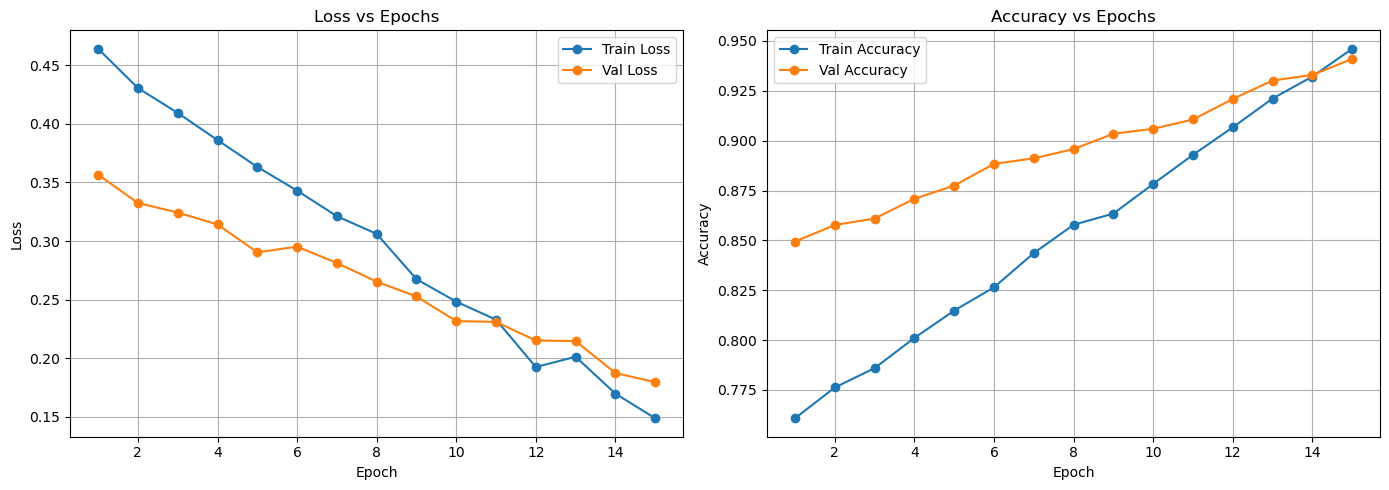

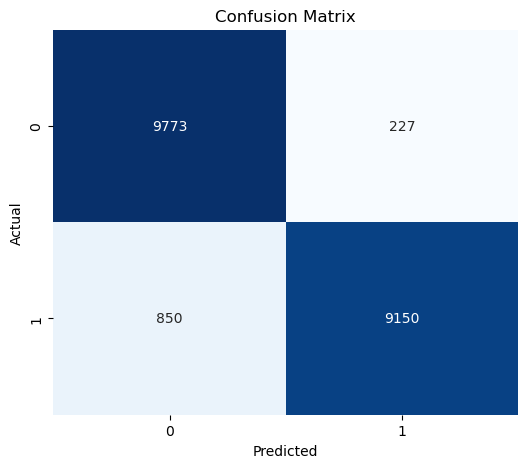

In [25]:

# Early stopping
best_loss = float('inf')
patience = 3
counter = 0
best_model_state = None

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

start_time = time.time()

for epoch in range(30):  # Increased upper limit
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---- Evaluation ----
    model.eval()
    test_loss = 0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    # ---- Early Stopping ----
    if test_loss < best_loss:
        best_loss = test_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f" Early stopping at epoch {epoch+1}")
            break

end_time = time.time()
print(f"\n Total Training Time: {(end_time - start_time):.2f} seconds")

# Restore best model
if best_model_state:
    model.load_state_dict(best_model_state)

# ---------------------------
# Evaluation Metrics
# ---------------------------
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

print("\n Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ---------------------------
# Loss & Accuracy Plots
# ---------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# LightweightCNN_HOC

In [ ]:
class HOCBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(HOCBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        linear = self.conv1(x)
        quadratic = self.conv2(x ** 2)  # Square input for higher-order
        out = linear + quadratic
        out = self.bn(out)
        return self.relu(out)
class LightweightCNN_HOC(nn.Module):
    def __init__(self):
        super(LightweightCNN_HOC, self).__init__()
        self.features = nn.Sequential(
            HOCBlock(3, 16),       # High-order conv
            nn.MaxPool2d(2),

            HOCBlock(16, 32),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


Epoch  1 | Train Loss: 0.5050 | Train Acc: 0.8043 | Val Loss: 0.4879 | Val Acc: 0.8470
Epoch  2 | Train Loss: 0.4913 | Train Acc: 0.8255 | Val Loss: 0.4150 | Val Acc: 0.8393
Epoch  3 | Train Loss: 0.4762 | Train Acc: 0.8302 | Val Loss: 0.3543 | Val Acc: 0.8482
Epoch  4 | Train Loss: 0.4414 | Train Acc: 0.8448 | Val Loss: 0.3088 | Val Acc: 0.8693
Epoch  5 | Train Loss: 0.3692 | Train Acc: 0.8482 | Val Loss: 0.2643 | Val Acc: 0.8929
Epoch  6 | Train Loss: 0.3204 | Train Acc: 0.8642 | Val Loss: 0.2642 | Val Acc: 0.9128
Epoch  7 | Train Loss: 0.3085 | Train Acc: 0.8835 | Val Loss: 0.2436 | Val Acc: 0.9294
Epoch  8 | Train Loss: 0.2892 | Train Acc: 0.9191 | Val Loss: 0.2216 | Val Acc: 0.9382
Epoch  9 | Train Loss: 0.2715 | Train Acc: 0.9297 | Val Loss: 0.2170 | Val Acc: 0.9360
Epoch 10 | Train Loss: 0.2651 | Train Acc: 0.9377 | Val Loss: 0.1373 | Val Acc: 0.9440
Epoch 11 | Train Loss: 0.2180 | Train Acc: 0.9548 | Val Loss: 0.0779 | Val Acc: 0.9559
Epoch 12 | Train Loss: 0.1653 | Train Acc: 

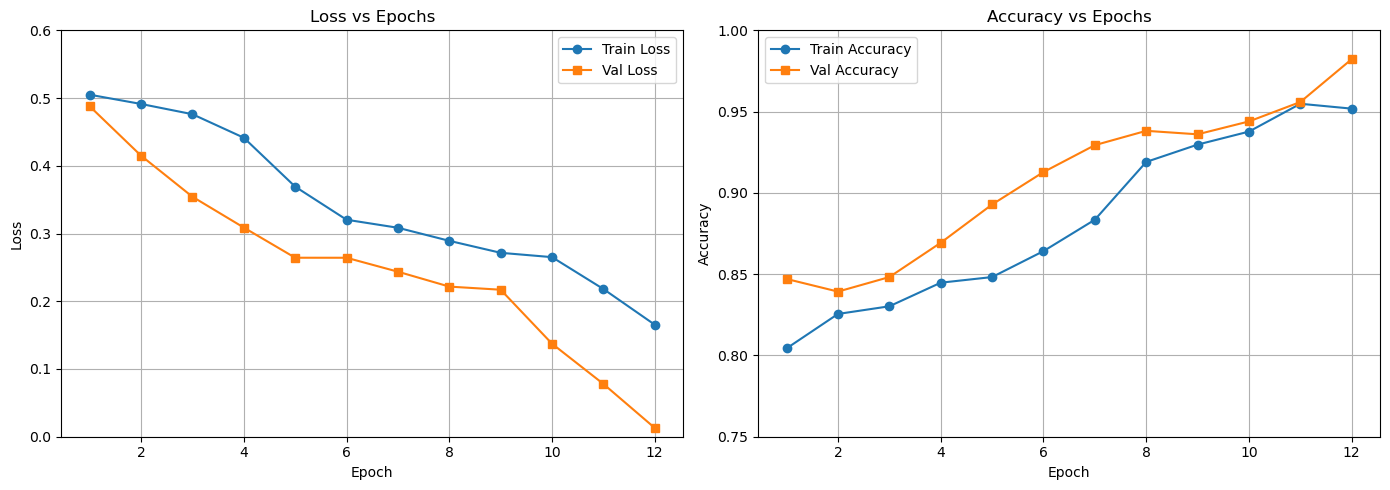

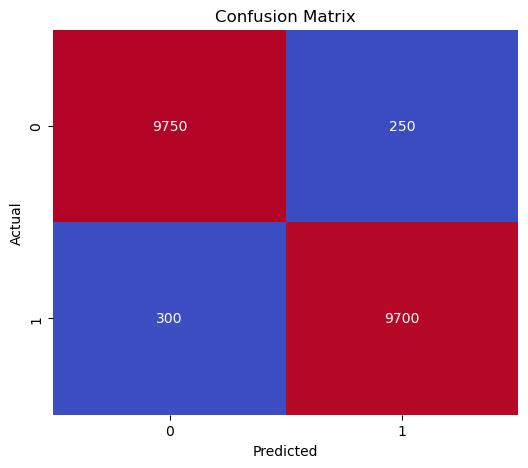

In [17]:
# ---------------------------
# Training Setup
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightweightCNN_HOC().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping
best_loss = float('inf')
patience = 3
counter = 0
best_model_state = None

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

start_time = time.time()

for epoch in range(30):  # Increased upper limit
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---- Evaluation ----
    model.eval()
    test_loss = 0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    # ---- Early Stopping ----
    if test_loss < best_loss:
        best_loss = test_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f" Early stopping at epoch {epoch+1}")
            break

end_time = time.time()
print(f"\n Total Training Time: {(end_time - start_time):.2f} seconds")

# Restore best model
if best_model_state:
    model.load_state_dict(best_model_state)

# ---------------------------
# Evaluation Metrics
# ---------------------------
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

print("\n Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ---------------------------
# Loss & Accuracy Plots
# ---------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
